In [1]:
import torch
import numpy as np
from Bio import SeqIO
from transformers import AutoTokenizer, EsmForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from latentmi import lmi
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
fn = '../DistributionEmbeddings/data/spikeprot0430/spikeprot0430.fasta'
ratios = np.logspace(-3, 6, 12)
noise_levels = 1 / (ratios+1)
print(noise_levels)
aas = list("ACDEFGHIKLMNPQRSTVWY")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_data(path, frac_to_read=0.01, lines_to_read=10**8):
    seqs, months = [], []
    iterator = SeqIO.parse(path, "fasta")
    for _ in tqdm(range(lines_to_read)):
        if np.random.rand() > frac_to_read:
            continue
        try:
            r = next(iterator)
            fields = r.description.split("|")
            date = (fields + ["?"] * 11)[2]
            
            # filter valid dates
            if len(date) == 10 and date[4] == '-' and '00' not in date:
                seqs.append(str(r.seq))
                yyyy_mm = date[:7]
                months_since_2020 = (int(yyyy_mm[:4]) - 2020) * 12 + int(yyyy_mm[5:7]) - 1
                months.append(months_since_2020)
        except:
            continue
    return seqs, np.array(months).reshape(-1, 1)

def mutate(seq_list, rate):
    # randomize aa based on rate
    noised = []
    for s in seq_list:
        s_arr = np.array(list(s))
        mask = np.random.rand(len(s_arr)) < rate
        s_arr[mask] = np.random.choice(aas, size=mask.sum())
        noised.append("".join(s_arr))
    return noised

class VirusDS(Dataset):
    def __init__(self, seqs, enc):
        self.enc = enc(seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)
    def __len__(self): return len(self.enc['input_ids'])
    def __getitem__(self, i): return {k: v[i] for k, v in self.enc.items()}

[9.99000999e-01 9.93463672e-01 9.58508457e-01 7.78329085e-01
 3.47969218e-01 7.50273809e-02 1.21783273e-02 1.87031280e-03
 2.84722497e-04 4.32857391e-05 6.57928896e-06 9.99999000e-07]


In [19]:
all_seqs, all_months = parse_data(fn, frac_to_read=0.0002)

  0%|          | 0/100000000 [00:00<?, ?it/s]

In [20]:
tr_seqs, te_seqs, _, te_months = train_test_split(all_seqs, all_months, test_size=0.75)

print(f"loaded {len(all_seqs)} seqs :)")

results = {}

loaded 18960 seqs :)


In [21]:
for nl in noise_levels:
    print(f"--- processing noise level: {nl} ---")
    
    # noising_process
    tr_n = mutate(tr_seqs, nl)
    te_n = mutate(te_seqs, nl)
    
    # 2. fresh model & tokenizer
    tok = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    net = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
    
    # finetune
    loader = DataLoader(VirusDS(tr_n, tok), batch_size=8, shuffle=True)
    optim = AdamW(net.parameters(), lr=1e-4)
    
    print('training')
    net.train()
    for i, batch in enumerate(loader):
        inp = batch['input_ids'].to(device)
        lbl = inp.clone()
        # mask 15% for training
        rand = torch.rand(inp.shape).to(device)
        msk = (rand < 0.15) & (inp != tok.cls_token_id) & (inp != tok.pad_token_id)
        inp[msk] = tok.mask_token_id
        
        loss = net(input_ids=inp, attention_mask=batch['attention_mask'].to(device), labels=lbl).loss
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i == 100: break # just for pilot, need to do full epoch at least eventually
        
    print("extracting embeddings...")
    net.eval()
    feats = []
    # minimal batching for eval
    with torch.no_grad():
        # process in chunks to save mem
        for i in range(0, len(te_n), 16):
            batch = te_n[i:i+16]
            inputs = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            # use mean pooling of last hidden state
            out = net.base_model(**inputs).last_hidden_state
            # mask out padding tokens for accurate mean
            mask = inputs.attention_mask.unsqueeze(-1).expand(out.size()).float()
            sum_embeddings = torch.sum(out * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            feats.append((sum_embeddings / sum_mask).cpu().numpy())

    X = np.vstack(feats)
    
    print("estimating mi...")
    pointwise, _, _ = lmi.estimate(X, te_months)
    avg_mi = np.nanmean(pointwise)
    
    results[nl] = avg_mi
    print(f"noise: {nl} -> mi: {avg_mi:.4f}")

print("done! final results:", results)

--- processing noise level: 0.9990009990009991 ---


training
extracting embeddings...
estimating mi...
epoch 52 (of max 300) 🌻noise: 0.9990009990009991 -> mi: 0.0076
--- processing noise level: 0.9934636724242178 ---
training
extracting embeddings...
estimating mi...
epoch 60 (of max 300) 🌻🌻noise: 0.9934636724242178 -> mi: -0.0212
--- processing noise level: 0.9585084570359224 ---
training
extracting embeddings...
estimating mi...
epoch 46 (of max 300) 🌻noise: 0.9585084570359224 -> mi: 0.0096
--- processing noise level: 0.7783290848811634 ---
training
extracting embeddings...
estimating mi...
epoch 50 (of max 300) 🌻noise: 0.7783290848811634 -> mi: 0.0134
--- processing noise level: 0.3479692175450291 ---
training
extracting embeddings...
estimating mi...
epoch 55 (of max 300) 🌻noise: 0.3479692175450291 -> mi: 0.0696
--- processing noise level: 0.0750273808989174 ---
training
extracting embeddings...
estimating mi...
epoch 46 (of max 300) 🌻noise: 0.0750273808989174 -> mi: 0.1893
--- processing noise level: 0.012178327283586383 ---
traini

In [22]:
res_df = pd.DataFrame(results.items(), columns=['noise_level', 'mutual_information'])
res_df = res_df[res_df['noise_level'] <= 1]
res_df['true/error'] = (1 - res_df['noise_level'])/res_df['noise_level']
res_df.to_csv('seq/pilot_results.csv', index=False)

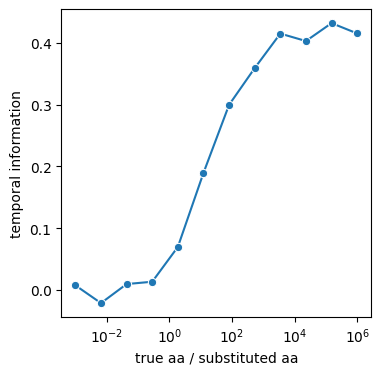

In [23]:
plt.figure(figsize=(4,4))
sns.lineplot(data=res_df, x='true/error', y='mutual_information', marker='o')
plt.xscale('log')
plt.ylabel('temporal information')
plt.xlabel('true aa / substituted aa')
plt.show()

In [24]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))


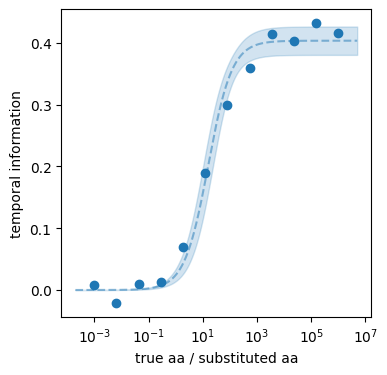

In [26]:
x_data = res_df['true/error']    
y_data = res_df['mutual_information']

palette = sns.color_palette("tab10", n_colors=10)

# create model and parameters
model = Model(info_scaling)
params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
params['A'].min = 0  # set bounds
params['B'].min = 0

# fit model
result = model.fit(y_data, params, x=x_data)

# generate fit line
x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
y_fit = model.eval(params=result.params, x=x_fit)

# calculate confidence bands
y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
y_lower = -y_upper


plt.figure(figsize=(4,4))
# plot fit and data
plt.plot(x_fit, y_fit, linestyle='--', color=palette[0], alpha=0.5)
plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[0], alpha=0.2)
plt.scatter(x_data, y_data, color=palette[0], label='Data')

plt.xscale('log')
plt.ylabel('temporal information')
plt.xlabel('true aa / substituted aa')
plt.show()